In [66]:
from pathlib import Path
import torch
import torch.nn as nn
from config import get_config, get_weights_file_path
from train import get_model, get_ds, run_validation

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [76]:
def loss_se(predicted: torch.Tensor, gt: torch.Tensor):
    """
    Calculate the squared error between two tensors.

    Args:
        tensor1 (torch.Tensor): The first tensor.
        tensor2 (torch.Tensor): The second tensor.

    Returns:
        torch.Tensor: The squared error between tensor1 and tensor2.
    """
    if predicted.shape != gt.shape:
        raise ValueError("Tensors must have the same shape.")

    squared_diff = (predicted - gt) ** 2

    return squared_diff

def plot_results(cfg: dict, gt: torch.Tensor, pred: torch.Tensor, src_input: torch.Tensor, inds: list):
    history = [i for i in range(0,cfg['src_seq_len'])]
    future = [i for i in range(cfg['src_seq_len'],cfg['src_seq_len']+cfg['val_seq_len'])]

    for gt_tensor, pred_tensor, src in zip(gt[inds], pred[inds], src_input[inds]):
        plt.figure()

        plt.plot(history, src, label="History", color='g')
        if cfg['val_seq_len'] == 1:
            plt.plot(future, gt_tensor, label="Ground Truth", marker='o', color='b')
            plt.plot(future, pred_tensor, label="Predicted", marker='o', color='r')
        else:
            plt.plot(future, gt_tensor, label="Ground Truth", color='b')
            plt.plot(future, pred_tensor, label="Predicted", color='r')

        # Add labels and legend
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()

        # Show the plot
        plt.show()

In [84]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
cfg = get_config()

train_dataloader, val_dataloader, label_scaler, val_dataloader_onebatch = get_ds(cfg)
model = get_model(cfg).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(cfg, f"08")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

if cfg['tgt_seq_len'] < cfg['val_seq_len']:
    raise ValueError("Tensors must have the same shape.")

Using device: cpu


In [ ]:
# calculate validation data
loss, ground_truth, predicted, src_input = run_validation(model, cfg, val_dataloader, label_scaler, device, lambda msg: print(msg), 0, None, 0)
ground_truth_tensor, predicted_tensor, src_input_tensor = torch.cat(ground_truth), torch.cat(predicted), torch.cat(src_input)

# get loss for each datapoint
se_loss_val = loss_se(predicted_tensor, ground_truth_tensor)

# calculate score metrics
r2 = r2_score(ground_truth_tensor.squeeze(1,2), predicted_tensor.squeeze(1,2))
rmse = mean_squared_error(ground_truth_tensor.squeeze(1,2), predicted_tensor.squeeze(1,2), squared=False)
mae = mean_absolute_error(ground_truth_tensor.squeeze(1,2), predicted_tensor.squeeze(1,2))

# get k random, best and worst predictions
k = 5
max_loss_inds = se_loss_val.squeeze(1,2).topk(k=k,largest=True).indices.tolist()
min_loss_inds = se_loss_val.squeeze(1,2).topk(k=k,largest=False).indices.tolist()
rand_inds = np.random.randint(0, len(ground_truth_tensor), size=k).tolist()

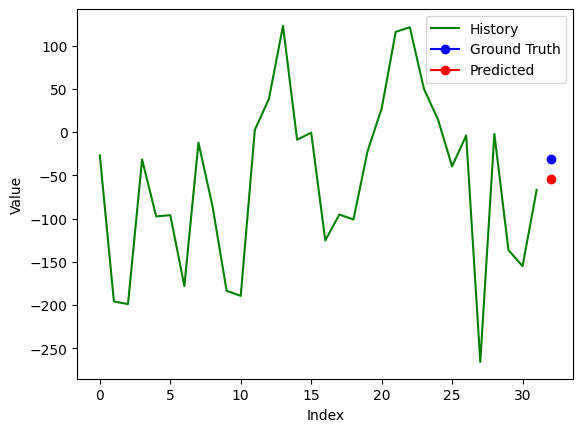

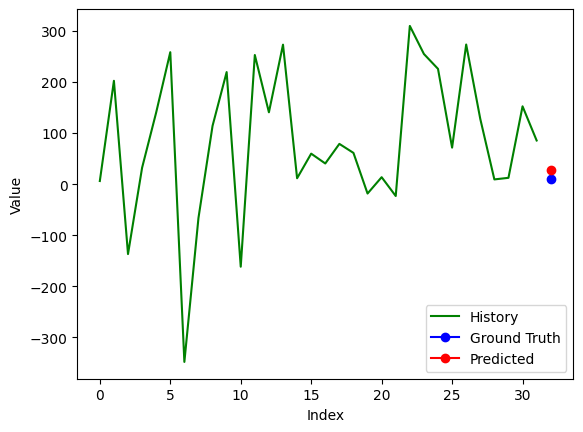

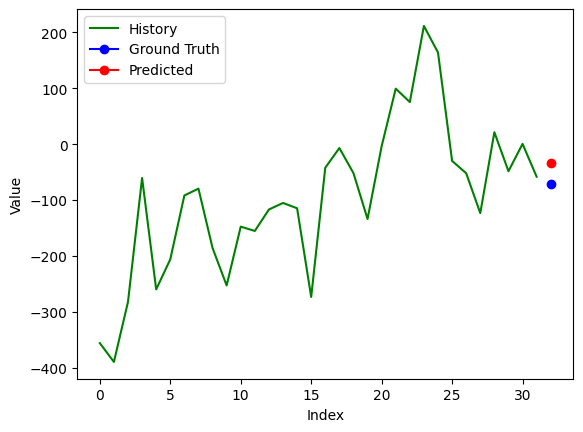

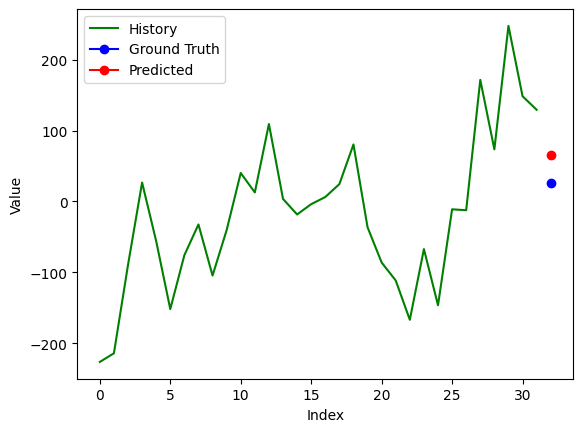

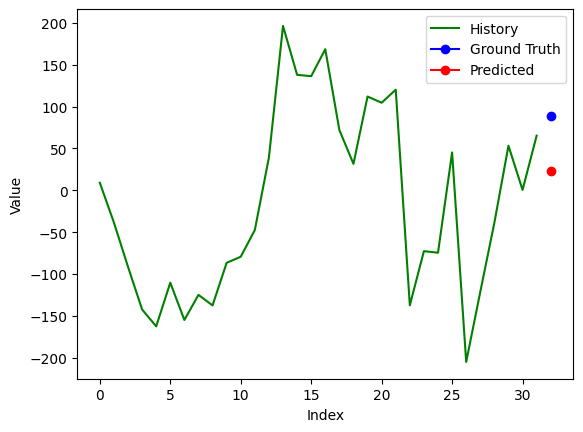

In [81]:
plot_results(cfg, ground_truth_tensor, predicted_tensor, src_input_tensor, inds=rand_inds)

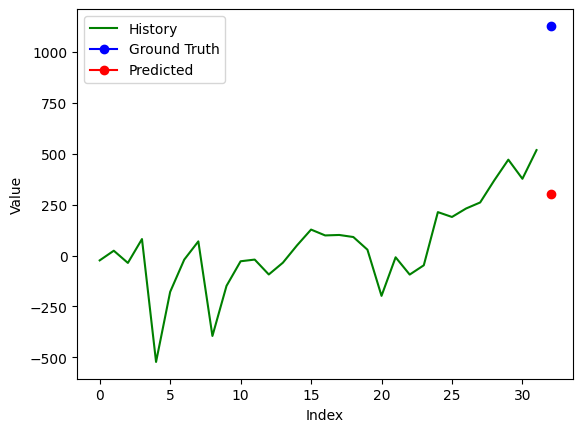

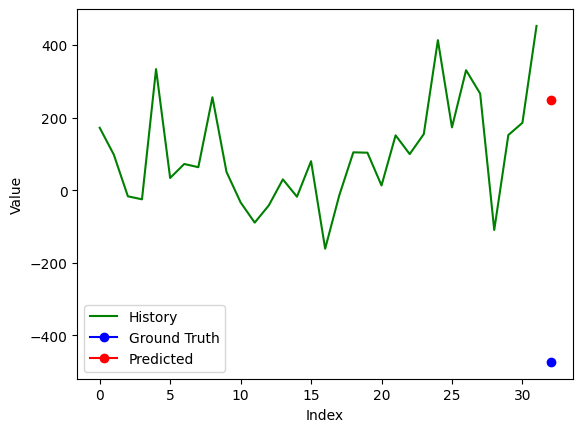

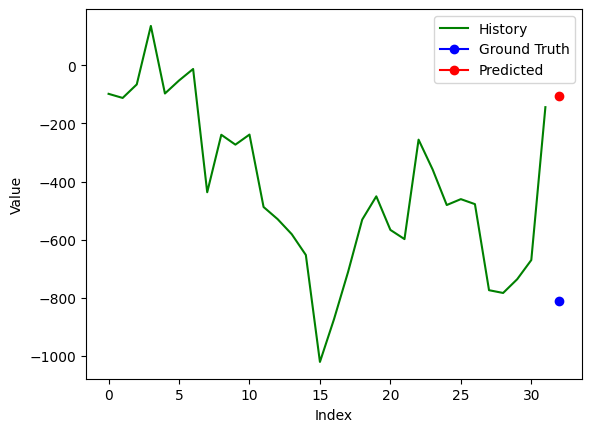

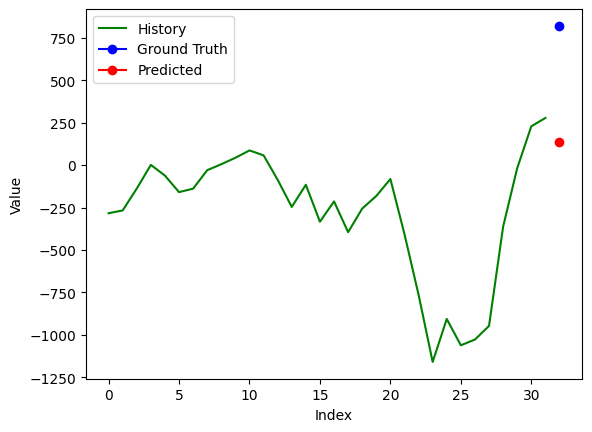

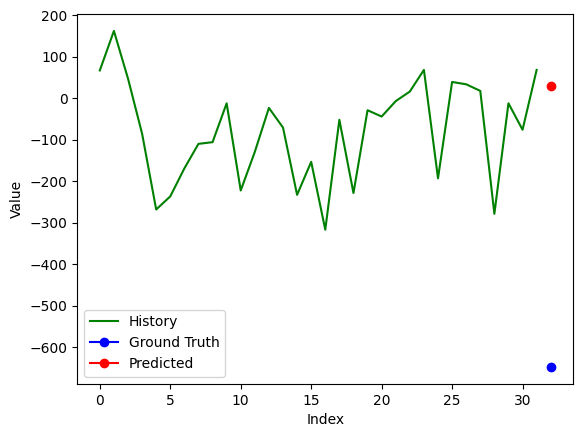

In [82]:
plot_results(cfg, ground_truth_tensor, predicted_tensor, src_input_tensor, inds=max_loss_inds)

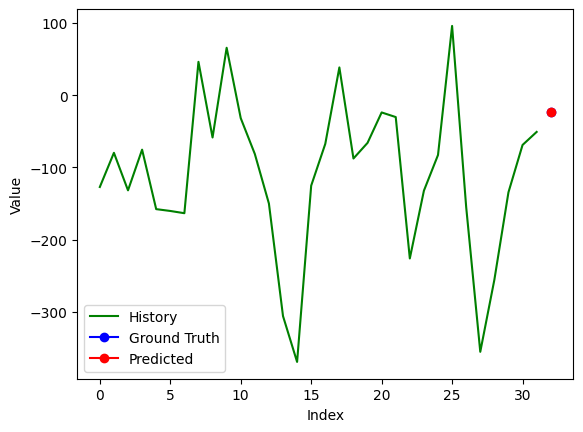

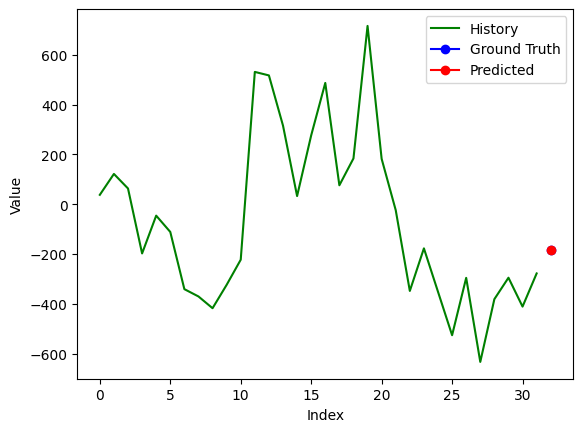

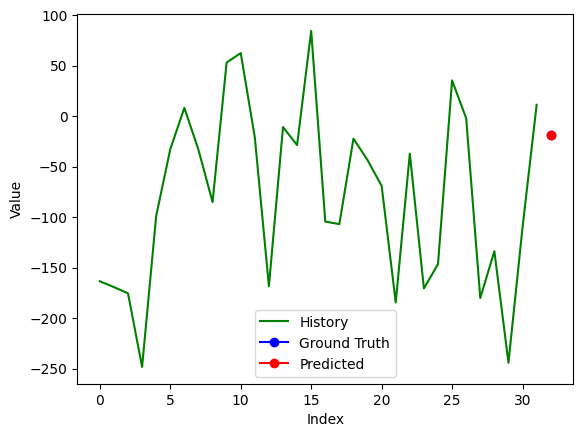

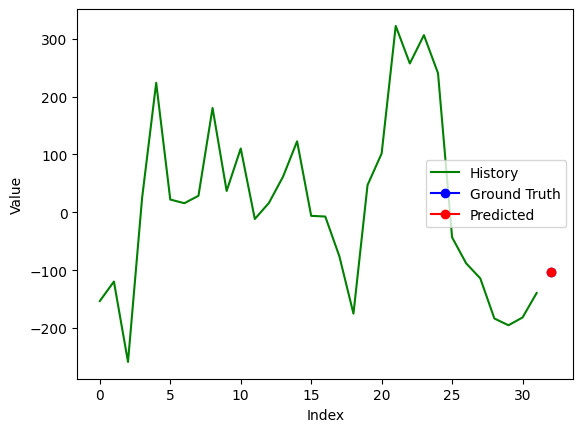

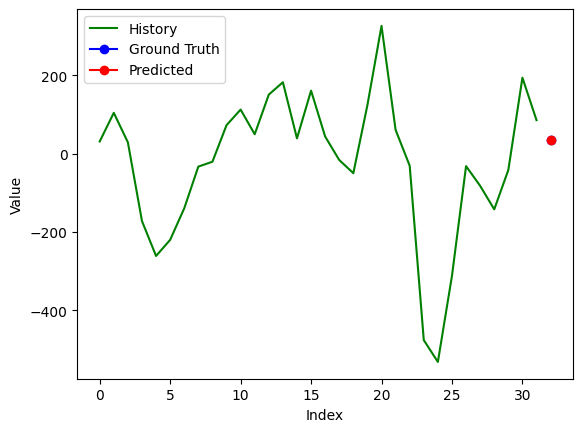

In [83]:
plot_results(cfg, ground_truth_tensor, predicted_tensor, src_input_tensor, inds=min_loss_inds)